In [1]:
#import libraries
import pandas as pd
import numpy as np
import ta
from ta import add_all_ta_features
from ta.utils import dropna
from ta.momentum import AwesomeOscillatorIndicator
from ta.momentum import AwesomeOscillatorIndicator
from ta.momentum import KAMAIndicator
from ta.momentum import PercentagePriceOscillator
from ta.momentum import ROCIndicator
from ta.momentum import RSIIndicator
from ta.momentum import UltimateOscillator
from ta.volume import ForceIndexIndicator
from ta.volume import AccDistIndexIndicator
from ta.volume import ChaikinMoneyFlowIndicator
from ta.volume import EaseOfMovementIndicator
from ta.volume import MFIIndicator
from ta.volume import VolumePriceTrendIndicator
from ta.volatility import BollingerBands
from ta.volatility import DonchianChannel
from ta.volatility import UlcerIndex
from ta.volatility import KeltnerChannel
from ta.trend import ADXIndicator
from ta.trend import AroonIndicator
from ta.trend import EMAIndicator
from ta.trend import MACD
from ta.trend import MassIndex
import os
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statistics import stdev
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from xgboost import XGBClassifier
import pandas as pd
import datetime as dt
import numpy as np
import random
import json
import pickle
from numpy import abs
from numpy import log
from numpy import sign
from scipy.stats import rankdata
import pandas as pd
from sklearn import preprocessing
import random
from random import sample
random.seed(1)
np.random.seed(1)

#BECAUSE WE ARE ANIMALS
import warnings
warnings.filterwarnings('ignore')

def computeRSI(data, time_window):
    diff = data.diff(1).dropna()  # diff in one field(one day)

    # this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff

    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[diff > 0]

    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[diff < 0]

    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg = up_chg.ewm(com=time_window - 1, min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window - 1, min_periods=time_window).mean()

    rs = abs(up_chg_avg / down_chg_avg)
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [2]:
#plain dataframe read
df = pd.read_csv('prc.csv')

In [3]:
# Careful, this might fuck ur computer
def fit_indicators(df_a):
    AwesomeOscillator = AwesomeOscillatorIndicator(high=df_a["high"],low=df_a["low"],window1 = 5,window2 =34)
    KAMA = KAMAIndicator(close = df_a["close"],window = 10,pow1 = 2, pow2 = 30)
    PPO = PercentagePriceOscillator(close = df_a["close"],window_slow = 26, window_fast = 12, window_sign = 9)
    ROCI = ROCIndicator(close=df_a["close"],window=12)
    RSI = RSIIndicator(close=df_a["close"],window = 14)
    UO = UltimateOscillator(high = df_a["high"] , low = df_a["low"],close = df_a["close"],window1=7,window2=14,window3=28,weight1=4.0,weight2=2.0,weight3=1.0)
    ADI = AccDistIndexIndicator(high = df_a["high"], low = df_a["low"], close= df_a["close"], volume = df_a["volume"])
    Chaikin = ChaikinMoneyFlowIndicator(high = df_a["high"], low = df_a["low"], close= df_a["close"],volume=df_a["volume"],window = 20)   
    EOM = EaseOfMovementIndicator(high = df_a["high"], low = df_a["low"],volume=df_a["volume"],window = 14)
    FII = ForceIndexIndicator(close = df_a["close"],volume = df_a["volume"], window = 13)
    MFI = MFIIndicator(high = df_a["high"], low = df_a["low"],close = df_a["close"],volume = df_a["volume"],window = 14)
    VPT = VolumePriceTrendIndicator(close = df_a["close"],volume = df_a["volume"])
    BB = BollingerBands(close = df_a["close"],window = 20, window_dev = 2)
    Ulcer = UlcerIndex(close = df_a["close"], window = 14)
    EMA10 = EMAIndicator(close = df_a["close"],window = 10)
    EMA25 = EMAIndicator(close = df_a["close"],window = 25)
    EMA40 = EMAIndicator(close = df_a["close"],window = 40)
#    EMA50 = EMAIndicator(close = df_a["close"],window = 50)
#    EMA100 = EMAIndicator(close = df_a["close"],window = 100)
    MACD_ind = MACD(close = df_a["close"],window_slow = 26,window_fast = 12,window_sign=9)
    Mass = MassIndex(high = df_a["high"],low = df_a["low"], window_fast = 9,window_slow = 25)
    Aroon = AroonIndicator(close = df_a["close"],window = 25)

    df_a = df_a.assign(AwesomeOscillator = AwesomeOscillator.awesome_oscillator(),KAMA = KAMA.kama(),PPO = PPO.ppo_signal(),
                      ROCI = ROCI.roc(),RSI = RSI.rsi(),UO = UO.ultimate_oscillator(), ADI = ADI.acc_dist_index(),
                      Chaikin = Chaikin.chaikin_money_flow(), EOM = EOM.ease_of_movement(),EOMS = EOM.sma_ease_of_movement(),
                      FII = FII.force_index(), MFI = MFI.money_flow_index(), VPT = VPT.volume_price_trend(),
                      BBHigh = BB.bollinger_hband(),BBLow=BB.bollinger_lband(),BBHighInd=BB.bollinger_hband_indicator(),
                      BBLowInd= BB.bollinger_lband_indicator(),Ulcer = Ulcer.ulcer_index(), AroonDown = Aroon.aroon_down(),
                      AroonUp = Aroon.aroon_up(),AroonInd = Aroon.aroon_indicator(),Mass=Mass.mass_index(),MACD = MACD_ind.macd_signal(),
                      EMA10 = EMA10.ema_indicator(),
                      EMA25 = EMA25.ema_indicator(),
                      EMA40 = EMA40.ema_indicator())
                      
    return df_a
df1 = (df.groupby('gvkey').apply(fit_indicators).apply(lambda group: group.iloc[50:])).reset_index(drop= True)

In [4]:
df1.head()

,date,gvkey,open,high,low,close,volume,AwesomeOscillator,KAMA,PPO,...,BBLowInd,Ulcer,AroonDown,AroonUp,AroonInd,Mass,MACD,EMA10,EMA25,EMA40
0,1999-03-15,1166,NaN,3.95,3.55,3.75,65020,-0.556471,4.151088,-2.836356,...,1.0,10.994020,100.0,20.0,-80.0,23.919850,-0.127261,4.155058,4.396859,4.488797
1,1999-03-16,1166,NaN,3.85,3.75,3.85,39685,-0.627059,4.101736,-3.253942,...,0.0,11.887511,96.0,16.0,-80.0,24.196835,-0.144795,4.099593,4.354792,4.457636
2,1999-03-17,1166,NaN,4.10,3.95,4.05,111680,-0.605000,4.098508,-3.556628,...,0.0,12.223238,92.0,12.0,-80.0,24.358795,-0.157230,4.090576,4.331347,4.437751
3,1999-03-18,1166,NaN,3.95,3.85,3.95,65770,-0.610000,4.088060,-3.802320,...,0.0,12.624587,88.0,8.0,-80.0,24.479992,-0.167055,4.065017,4.302013,4.413959
4,1999-03-19,1166,NaN,4.10,4.00,4.00,41693,-0.572941,4.083132,-3.972216,...,0.0,12.861118,84.0,4.0,-80.0,24.527760,-0.173549,4.053195,4.278781,4.393765


In [5]:
#Add more, cooler features and other stuff we need later
#TODO there is a problem where some of these will be calculated across two companies because they are overlapping in the rows
#Somebody fix this pls

df = df1

times = [3, 4, 5]
df[f'return'] = df[f'close'].pct_change()
df[f'return future'] = df[f'return'].shift(-1)
for time in times:
    df[f'RET {time}'] = df[f'close'].pct_change(time - 1)
    df[f'STD {time}'] = df[f'return'].rolling(time).std()
    df[f'EMA {time}'] = df[f'close'] / df[f'close'].ewm(span=time, adjust=False).mean() - 1
    df[f'SH {time}'] = df[f'return'].rolling(time).mean() / df[f'STD {time}']
    df[f'RSI {time}'] = computeRSI(df[f'close'], time) # MORE RSI ITS SO GOOODO

df1 = df

In [6]:
#test stationarity with ADF test for all columns. Drop or normalize those which have a p-value above 0.05
df_one_stock = df1[df1['gvkey']==1166]
df_one_stock = df_one_stock.set_index('date')
for i in df_one_stock.columns:
    col = df_one_stock[i]
    col = col.dropna()
    np.nan_to_num(col)
    from statsmodels.tsa.stattools import adfuller
    X = col
    result = adfuller(X)
#     print('ADF Statistic: %f' % result[0])
    print(i, 'p-value: %f' % result[1])
#     print('Critical Values:')
#     for key, value in result[4].items():
#         print('\t%s: %.3f' % (key, value)) 

gvkey p-value: nan
open p-value: 0.995751
high p-value: 1.000000
low p-value: 1.000000
close p-value: 1.000000
volume p-value: 0.000000
AwesomeOscillator p-value: 0.000000
KAMA p-value: 1.000000
PPO p-value: 0.000000
ROCI p-value: 0.000000
RSI p-value: 0.000000
UO p-value: 0.000000
ADI p-value: 0.434400
Chaikin p-value: 0.000000
EOM p-value: 0.000000
EOMS p-value: 0.000000
FII p-value: 0.000000
MFI p-value: 0.000000
VPT p-value: 0.000000
BBHigh p-value: 1.000000
BBLow p-value: 1.000000
BBHighInd p-value: 0.000000
BBLowInd p-value: 0.000000
Ulcer p-value: 0.000000
AroonDown p-value: 0.000000
AroonUp p-value: 0.000000
AroonInd p-value: 0.000000
Mass p-value: 0.000000
MACD p-value: 0.000000
EMA10 p-value: 1.000000
EMA25 p-value: 1.000000
EMA40 p-value: 1.000000
return p-value: 0.000000
return future p-value: 0.000000
RET 3 p-value: 0.000000
STD 3 p-value: 0.000000
EMA 3 p-value: 0.000000
SH 3 p-value: 0.000000
RSI 3 p-value: 0.000000
RET 4 p-value: 0.000000
STD 4 p-value: 0.000000
EMA 4 p

In [7]:
#normalize those who fail things !IF YOU RUN MORE THAN ONCE THINGS GET CRAZY 
df1['KAMA'] = df1['KAMA'] / df1['close']-1
df1['EMA10'] = df1['EMA10'] / df1['close']-1
df1['EMA25'] = df1['EMA25'] / df1['close']-1
df1['EMA40'] = df1['EMA40'] / df1['close']-1
df1['BBHigh'] = df1['BBHigh'] / df1['close']-1
df1['BBLow'] = df1['BBLow'] / df1['close']-1
df1 = df1.drop('ADI',axis=1)

In [ ]:
# Sample x stocks
subset = 50
num_stocks=df1['gvkey'].value_counts()
name_list = list(num_stocks.index)
random_keys = sample(name_list,subset)
df_sample = df1[df1['gvkey'].isin(random_keys)]
df_sample['date'] = pd.to_datetime(df_sample['date'], format='%Y-%m-%d')

In [50]:
df_sample = df_sample.sort_values(by=['date']) # needs to be sorted by time so we get no problem with look-ahead bias
df_sample = df_sample.tail(len(df_sample)-4*100) #combat spillover from my feature engineering
df_sample

,date,gvkey,open,high,low,close,volume,AwesomeOscillator,KAMA,PPO,...,RET 4,STD 4,EMA 4,SH 4,RSI 4,RET 5,STD 5,EMA 5,SH 5,RSI 5
3308627,1999-02-05,210493,NaN,54.500000,52.400000,54.500000,485,NaN,-0.005193,NaN,...,-0.036251,0.049809,0.003932,-0.416759,0.469101,-0.084034,0.047911,0.000358,-0.238659,0.447827
2145515,1999-02-05,103329,NaN,18.700000,18.300000,18.700000,13410,NaN,0.007940,NaN,...,-0.007958,0.014862,-0.002099,-0.039315,0.291798,-0.002667,0.013442,-0.004555,0.085217,0.178743
2293784,1999-02-05,104733,NaN,19.338619,18.899105,18.899105,6140,NaN,-0.000264,NaN,...,-0.042316,0.016294,-0.016988,-0.483470,0.196141,-0.031532,0.014546,-0.019801,-0.433261,0.234953
4969018,1999-02-05,225087,NaN,48.900000,44.600000,47.600000,29868,NaN,-0.072433,NaN,...,-0.016529,0.036837,0.011161,0.013930,0.619831,0.000000,0.032487,0.014797,0.091228,0.635781
3954805,1999-02-05,216039,NaN,4.500000,4.300000,4.300000,1300,NaN,0.011823,NaN,...,-0.138277,0.033824,-0.044640,-1.425985,0.366869,-0.180952,0.194456,-0.043508,0.194028,0.302609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258587,2021-03-02,101364,8.410,8.470000,8.220000,8.220000,143495,0.463176,0.000276,3.670161,...,0.022388,0.036826,0.002320,0.013489,0.521712,0.000000,0.032644,0.002879,0.110624,0.519629
5861223,2021-03-02,233064,0.418,0.418000,0.404000,0.410000,77010,-0.002674,0.018214,1.686544,...,-0.014423,0.008905,-0.008305,-0.670839,0.351948,-0.023810,0.009003,-0.009581,-0.477776,0.386749
3576223,2021-03-02,211498,1.900,1.900000,1.862000,1.892000,154263,0.121300,0.020920,1.720970,...,-0.042510,0.022745,-0.006619,-0.488110,0.446453,-0.044444,0.022986,-0.006812,-0.252541,0.493991
8104197,2021-03-02,254818,2.910,2.915000,2.850000,2.870000,206868,0.141706,-0.015687,1.211885,...,0.014134,4.618753,0.001961,-0.000674,0.542382,-0.013746,0.000000,0.003448,inf,0.546518


In [51]:
df = df_sample
df = df.reset_index(drop=True)
dfgv = df #backup because we need the gvkey later

In [52]:
# drop those uncool non-normalized bitches
df = df.drop('volume date open high low close gvkey'.split(),axis=1)
df

,AwesomeOscillator,KAMA,PPO,ROCI,RSI,UO,Chaikin,EOM,EOMS,FII,...,RET 4,STD 4,EMA 4,SH 4,RSI 4,RET 5,STD 5,EMA 5,SH 5,RSI 5
0,NaN,-0.005193,NaN,-7.234043,36.564998,NaN,-0.311372,97422.680412,-701190.947428,-54.163420,...,-0.036251,0.049809,0.003932,-0.416759,0.469101,-0.084034,0.047911,0.000358,-0.238659,0.447827
1,NaN,0.007940,NaN,-9.661836,33.408840,NaN,-0.230502,-745.712155,-1133.132474,-1909.278879,...,-0.007958,0.014862,-0.002099,-0.039315,0.291798,-0.002667,0.013442,-0.004555,0.085217,0.178743
2,NaN,-0.000264,NaN,-7.725322,37.027980,NaN,0.117462,-1415.760249,-149.493788,-44.133962,...,-0.042316,0.016294,-0.016988,-0.483470,0.196141,-0.031532,0.014546,-0.019801,-0.433261,0.234953
3,NaN,-0.072433,NaN,22.997416,63.165476,NaN,0.078162,7198.339360,8951.263928,11799.160231,...,-0.016529,0.036837,0.011161,0.013930,0.619831,0.000000,0.032487,0.014797,0.091228,0.635781
4,NaN,0.011823,NaN,16.216216,54.677350,NaN,-0.069852,-3846.153846,892.595982,507.063619,...,-0.138277,0.033824,-0.044640,-1.425985,0.366869,-0.180952,0.194456,-0.043508,0.194028,0.302609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125190,0.463176,0.000276,3.670161,-4.418605,57.362072,44.004604,0.231857,19.164431,-5.432377,11432.454883,...,0.022388,0.036826,0.002320,0.013489,0.521712,0.000000,0.032644,0.002879,0.110624,0.519629
125191,-0.002674,0.018214,1.686544,-2.612827,50.019496,54.858859,-0.080092,-0.027269,-0.012056,-10.386920,...,-0.014423,0.008905,-0.008305,-0.670839,0.351948,-0.023810,0.009003,-0.009581,-0.477776,0.386749
125192,0.121300,0.020920,1.720970,7.134768,57.336726,52.324500,-0.040052,-1.009964,0.169339,2071.164243,...,-0.042510,0.022745,-0.006619,-0.488110,0.446453,-0.044444,0.022986,-0.006812,-0.252541,0.493991
125193,0.141706,-0.015687,1.211885,0.174520,55.216443,47.922526,0.113965,0.235658,-0.063246,1520.251637,...,0.014134,4.618753,0.001961,-0.000674,0.542382,-0.013746,0.000000,0.003448,inf,0.546518


In [53]:
df.isnull().sum(axis = 0)
#maybe we wanna think about not dropping NaNs

AwesomeOscillator    11391
KAMA                  2807
PPO                   1250
ROCI                   389
RSI                    423
UO                   10075
Chaikin                627
EOM                   2114
EOMS                  6552
FII                    423
MFI                   6300
VPT                      0
BBHigh                 627
BBLow                  627
BBHighInd                0
BBLowInd                 0
Ulcer                  423
AroonDown              801
AroonUp                801
AroonInd               801
Mass                  2485
MACD                  1250
EMA10                  290
EMA25                  801
EMA40                 1546
return                   0
return future            0
RET 3                    0
STD 3                    0
EMA 3                    0
SH 3                   209
RSI 3                    0
RET 4                    0
STD 4                    0
EMA 4                    0
SH 4                   612
RSI 4                    0
R

In [54]:
df = df.dropna()

In [55]:
df

,AwesomeOscillator,KAMA,PPO,ROCI,RSI,UO,Chaikin,EOM,EOMS,FII,...,RET 4,STD 4,EMA 4,SH 4,RSI 4,RET 5,STD 5,EMA 5,SH 5,RSI 5
257,-0.751577,0.074129,0.138209,-17.938931,31.858297,23.168344,-0.315503,-796.930960,-214.466023,-31490.586435,...,-0.098532,0.021587,-0.048834,-1.201140,0.048206,-0.100418,0.019390,-0.058779,-1.218673,0.091783
259,4.777941,-0.077069,0.944507,5.550500,58.683544,69.563921,-0.247737,28371.407517,-27638.221697,-438.450911,...,0.002593,0.007293,0.002618,-0.407467,0.678869,-0.011925,0.008394,0.005092,-0.099156,0.668749
261,-5.994064,0.141351,-4.545868,-14.912281,34.018955,41.186661,0.116665,-4661.667287,-1272.195217,-25146.351842,...,-0.072658,0.049544,-0.038468,-0.063853,0.238181,-0.016227,0.046253,-0.044096,-0.235409,0.266961
267,-0.001972,-0.061767,-2.612821,1.308017,51.549618,44.700818,-0.107383,56151.266200,13464.328362,37.407124,...,0.016511,0.052085,0.021184,0.443726,0.608057,0.091364,0.054122,0.024020,0.180954,0.588615
268,-1.475441,0.050478,-2.547447,-8.510638,26.709501,48.635605,0.136397,373.971578,-1041.710688,-652.891033,...,-0.036415,0.009386,-0.013711,-1.491159,0.122858,-0.054945,0.009563,-0.018624,-1.228080,0.152529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125190,0.463176,0.000276,3.670161,-4.418605,57.362072,44.004604,0.231857,19.164431,-5.432377,11432.454883,...,0.022388,0.036826,0.002320,0.013489,0.521712,0.000000,0.032644,0.002879,0.110624,0.519629
125191,-0.002674,0.018214,1.686544,-2.612827,50.019496,54.858859,-0.080092,-0.027269,-0.012056,-10.386920,...,-0.014423,0.008905,-0.008305,-0.670839,0.351948,-0.023810,0.009003,-0.009581,-0.477776,0.386749
125192,0.121300,0.020920,1.720970,7.134768,57.336726,52.324500,-0.040052,-1.009964,0.169339,2071.164243,...,-0.042510,0.022745,-0.006619,-0.488110,0.446453,-0.044444,0.022986,-0.006812,-0.252541,0.493991
125193,0.141706,-0.015687,1.211885,0.174520,55.216443,47.922526,0.113965,0.235658,-0.063246,1520.251637,...,0.014134,4.618753,0.001961,-0.000674,0.542382,-0.013746,0.000000,0.003448,inf,0.546518


In [647]:
# make it a classification problem
df['Target'] = np.where(df['return future'] > 0.001, 1, 0) #play around with this and see the results
y = df['Target']
X = df.drop(['Target','return future'], axis=1)

In [648]:
y.sum() / len(y) #imbalance

0.4281314353842263

In [707]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# good set for future grid searches
grid = {
    'max_depth': [1, 2, 3, 4, 6, 9],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.3, 0.4],
    # 'gamma': [0.0, 0.25, 1, 5],
    # 'colsample_bytree': [0.4, 0.8, 1],
}

xgb = XGBClassifier(
                    class_weight='balanced',
                    max_depth=3,
                    learning_rate=0.3,
                    gamma=0,
                    scale_pos_weight=1.5, #forces to give more aggressive positive outcomes
                    verbosity=0)
xgb.fit(X_train, y_train)
predicted_proba = xgb.predict_proba(X_test)

In [708]:
threshold = 0.5 #play around with this and see the results
predictions_pos = (predicted_proba [:,1] > (threshold)).astype('int')
predictions_neg = (predicted_proba [:,0] < (1-threshold)).astype('int')
w
tx_cost = 0.001
df2 = X_test
df2['gvkey'] = dfgv['gvkey'] # reassign key 

df2['Target Return Future'] = df['return future'] 
df2['Predictions Pos'] = predictions_pos
df2['Pred Pos Return'] = np.where(df2['Predictions Pos'] == 1, df2[f'Target Return Future'] - tx_cost, 0)
df2['Predictions Neg'] = predictions_neg
df2['Pred Neg Return'] = np.where(df2['Predictions Neg'] == 1, - df2[f'Target Return Future'] - tx_cost, 0)
df2['Pred All Return'] = df2['Pred Neg Return'] + df2['Pred Pos Return']

In [ ]:
### ALTERNATIVE SIGNAL GENERATION BASED ON ROLLING PROBABILITY WINDOW


# window = 250
# thresh = 0.5
# df2['Predictions Minus'] = predicted_proba[:, 0]
# df2['Predictions Plus'] = predicted_proba[:, 1]

# tx_cost = 0.001
# df2 = X_test
# df2['gvkey'] = dfgv['gvkey'] # reassign key 

# df2['Target Return Future'] = df['return future'] 
# df2['Predictions Pos'] = np.where(df2['Predictions Plus'].rolling(window).quantile(thresh) < df2['Predictions Plus'], 1, 0)
# df2['Pred Pos Return'] = np.where(df2['Predictions Pos'] == 1, df2[f'Target Return Future'] - tx_cost, 0)
# df2['Predictions Neg'] = np.where(df2['Predictions Minus'].rolling(window).quantile(thresh) < df2['Predictions Minus'], 1, 0)
# df2['Pred Neg Return'] = np.where(df2['Predictions Neg'] == 1, - df2[f'Target Return Future'] - tx_cost, 0)
# df2['Pred All Return'] = df2['Pred Neg Return'] + df2['Pred Pos Return']

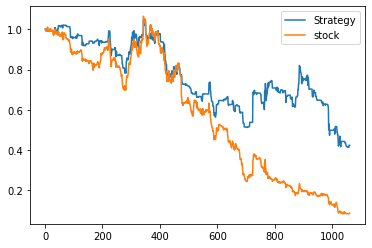

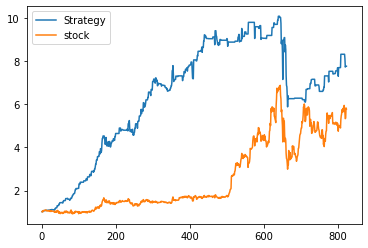

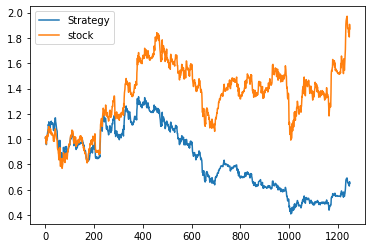

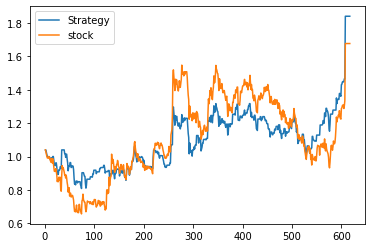

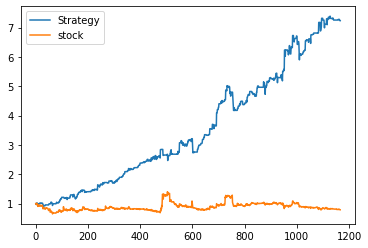

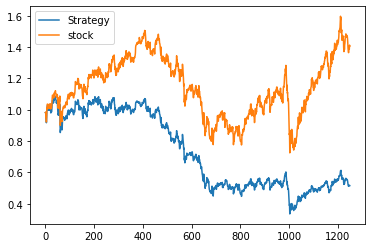

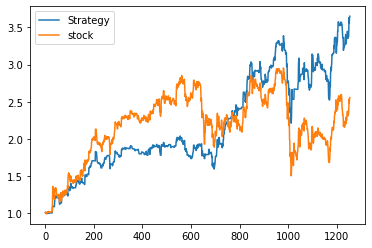

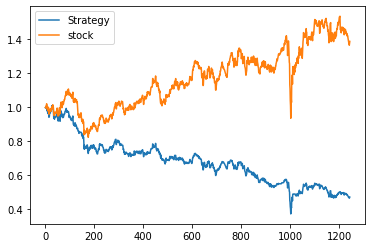

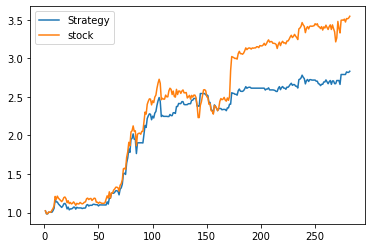

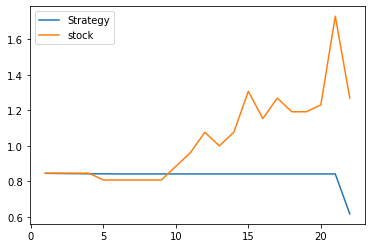

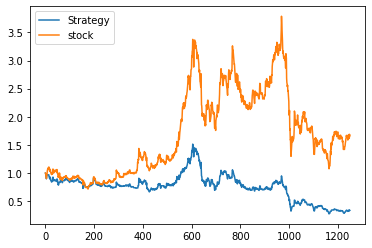

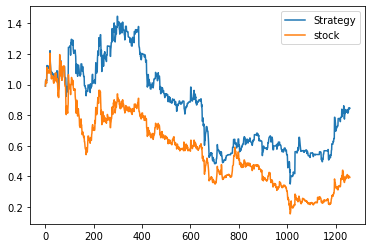

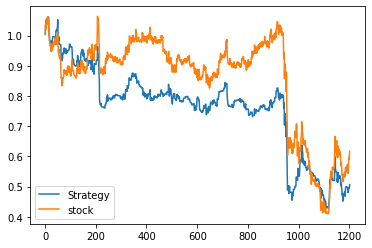

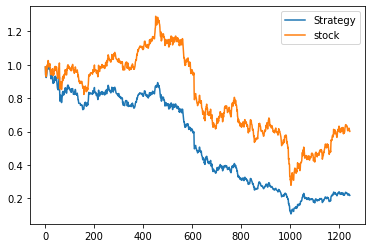

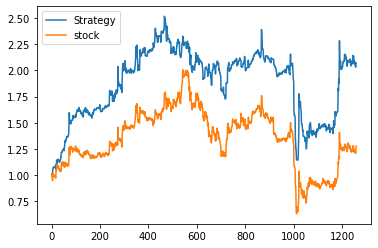

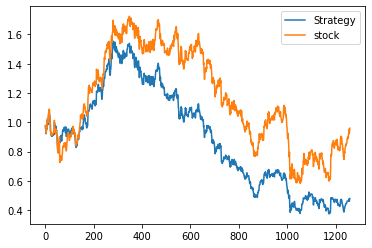

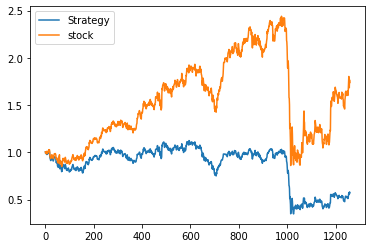

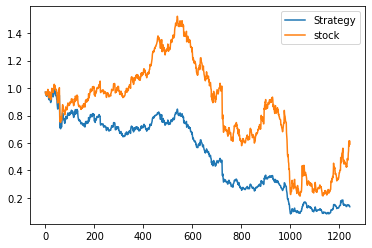

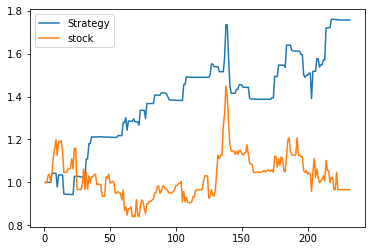

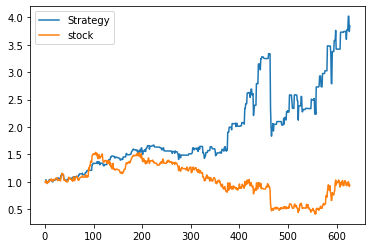

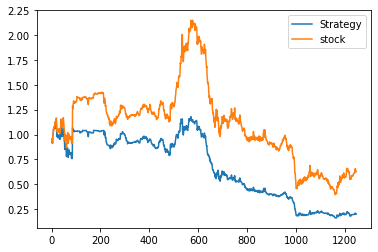

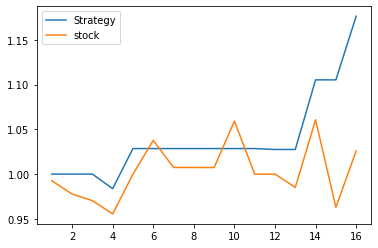

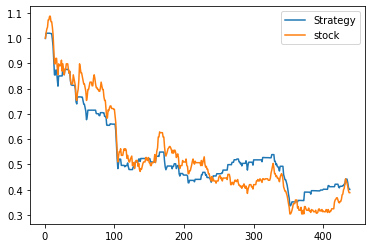

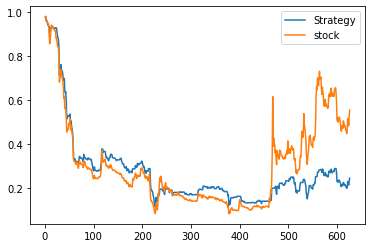

___________________________________________________
Outperfomance ratio: 0.6666666666666666


In [713]:
#look at performance of each stock
outperformance_count = 0
stockos = df2['gvkey'].unique()
for stocki in stockos:
    df33 = df2[df2['gvkey']==stocki]

    df33 = df33.reset_index()
    df33['Strategy'] = (df33['Pred Pos Return'].shift(1) + 1).cumprod()
    df33['Strategy'].plot(legend='Strategy')
    
#     df33['Strategy Market Neutral'] = (df33['Pred All Return'].shift(1) + 1).cumprod()
#     df33['Strategy Market Neutral'].plot(legend='Strategy Market Neutral')

    df33['stock'] = (df33['Target Return Future'].shift(1) + 1).cumprod()
    df33['stock'].plot(legend='stock')
    plt.show()
    # Metrics
    signal_ratio = df33['Predictions Pos'].describe()[1]
    meanret = df33['Pred Pos Return'].mean() * 10000 * (1/signal_ratio)
    
    try:
        strategy_sharpe = df33['Pred Pos Return'].mean() / df33['Pred Pos Return'].std()
        benchsharpe = df33['return'].mean() / df33['return'].std()
    except ZeroDivisionError as e:
        strategy_sharpe = 0
        benchsharpe = 0
    if strategy_sharpe > benchsharpe:
        outperformance_count += 1
    totret = df33['Pred Pos Return'].sum() * 100
    n_of_trades = df33['Predictions Pos'].sum()
#     print(stocki)
#     print("Sharpe : ", strategy_sharpe)
#     print("Benchmark Sharpe : ", benchsharpe)
#     print("Mean Return in bp per Trade: ", meanret)
#     print("Total Return %: ", totret)
#     print("Number of trades :", n_of_trades)
    
print("___________________________________________________")
print("Outperfomance ratio:", outperformance_count / len(df2['gvkey'].unique()))

In [710]:
# import seaborn as sns
# tmp = pd.DataFrame({'Feature': X, 'Feature importance': xgb.feature_importances_})
# tmp = tmp.sort_values(by='Feature importance',ascending=False)
# plt.figure(figsize = (7,4))
# plt.title('Features importance',fontsize=14)
# s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
# s.set_xticklabels(s.get_xticklabels(),rotation=90)
# plt.show()

# for t in tmp.Feature:
#     print(t)

In [711]:
predictions_pos.sum()

15777

In [695]:
len(df2['gvkey'].unique())

24

In [696]:
predictions_neg.sum()

22144

In [697]:
len(predicted_proba)

22144